## Classifying Traffic Signs

This notebook presents how to train a image classifier based on Mobilenet v2 architecture. 

**It is possible to execute each cell click in "Run" or pressing "Shift+Enter".**

Reference:
MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications (Mobilenet V1)

https://arxiv.org/abs/1704.04861

MobileNetV2: Inverted Residuals and Linear Bottlenecks

http://openaccess.thecvf.com/content_cvpr_2018/html/Sandler_MobileNetV2_Inverted_Residuals_CVPR_2018_paper.html

### Import modules

In [1]:
import keras
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.preprocessing import image
from keras.applications.mobilenet_v2 import preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications.imagenet_utils import decode_predictions
from keras.optimizers import Adam

import numpy as np
import time
import matplotlib.pyplot as plt
import random


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarn

### Variables declaration

Some hyperparameters (variables) used to build the neural network are defined here. The Mobilenet papers present hyperparameters used to change the size and learning capacity of the model, such as width multiplier (alpha), input size, and resolution multiplier. 

This tutorial only changes the multiplier width to half of the original model, in order to construct a smaller and less computationally expensive model.

* If mobiletnet_alpha = 1, default number of filters from the paper are used at each layer.
* If mobiletnet_alpha < 1.0, proportionally decreases the number of filters in each layer.
* If mobiletnet_alpha > 1.0, proportionally increases the number of filters in each layer.

In [3]:
# Path of train and validation datasets
dataset_train_path = "./dataset/train"
dataset_validation_path = "./dataset/validation"

# Path to the local where the trained model will be saved
# "." points to the current folder where jupyter notebook was called
# "/model" is a folder inside directory "mobilenet_classification_lecture"
output_model_path = "./model"

input_image_size = 224
mobiletnet_alpha = 0.5

# number of images loaded at once to train the neural network
batch_size = 16

# classes that are going to be classified
classes = ['background',
           'traf_sign_60',
           'traf_sign_free',
           'traf_sign_stop']


### Functions declaration

Info about MobileNetV2 function: https://keras.io/applications/#mobilenetv2

The MobileNetV2 model present in Keras API was trained in the Imagenet dataset that contains 1000 classes. This tutorial will classify just 4 classes, for this reason it is necessary to delete the last layers of the original model (fully-connected and sigmoid layers), and add new ones for this problem.

In [10]:
# method used to create the model of the neural network
def build_mobilenet_v2(image_size, alpha, classes):
    
    # how many classes do we have
    num_classes = len(classes)

    # Load moblenetv2 model without last layers setting include_top=False
    base_model = MobileNetV2(input_shape=(image_size, image_size, 3), 
                        alpha=alpha,  
                        include_top=False, 
                        weights='imagenet', 
                        input_tensor=None, 
                        pooling=None, 
                        classes=1000)

    # Append new class classificaiton layers
    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # add a fully-connected layer ()
    x = Dense(1024, activation='relu')(x)
    
    # Multinomial logistic regression layer with the number of classes
    # This layers predict a probability value for each class
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # merge the mobilenet layers with the layers defined for this tutorial
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

# method used to print images in the notebook
def plot_images(images, fig_size=(12,6), rows=1, interp=False, titles=None, rescaled=False):
    
    # to show the image, we need to put the image by to the normal data type
    # firts multiply by 255 and then convert to uint8
    if rescaled == True:
        images = images * 255
        images = images.astype(np.uint8)
    
    if type(images[0]) is np.ndarray:
        images = np.array(images).astype(np.uint8)
        if images.shape[-1] != 3:
            images = images.transpose((0, 2, 3, 1))
        
    fig = plt.figure(figsize=fig_size)
    cols = len(images)//rows if len(images)%2 == 0 else len(images)//rows + 1
    
    for ind, image in enumerate(images):
        sub_plot = fig.add_subplot(rows, cols, ind+1)
        sub_plot.axis('Off')
        
        if titles is not None:
            sub_plot.set_title(titles[ind], fontsize=16)
            
        plt.imshow(image, interpolation=None if interp else 'none')

### Load model

In [4]:
# Build model
model = build_mobilenet_v2(input_image_size, mobiletnet_alpha, classes=classes)

# Show the model
model.summary()

3203072/3201480 [==============================] - 2s 1us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 16) 432         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 16) 64          Conv1[0][0]                      
______________________________________________

### Load datasets

In [12]:
# Load training dataset in batches from the "train" folder
# Normalize each image, dividing each pixel by 255 (rescale=1.0/255.0)
# Each pixel must have values between 0 and 1
# This helps the neural newtwork to learn
# REMEMBER: it is necessary to normalize every image to train and test the model
train_batches = image.ImageDataGenerator(rescale=1.0/255.0).flow_from_directory(dataset_train_path, 
                                                               target_size=(224,224),
                                                               batch_size=batch_size,
                                                               classes=classes)

# Load valiation dataset in batches from the "validation" folder
validation_batches = image.ImageDataGenerator(rescale=1.0/255.0).flow_from_directory(dataset_validation_path, 
                                                                    target_size=(224,224), 
                                                                    batch_size=batch_size,
                                                                    classes=classes)

# Number of samples used in one epoch = batch_size * steps_per_epochs
step_size = train_batches.n//train_batches.batch_size

print("\nBatch size: " + str(batch_size))
print("Step size: " + str(step_size))

print("\nClasses: ")
for i, class_ in enumerate(classes):
    print("[" + str(i) + "] - " + class_ )

Found 840 images belonging to 4 classes.
Found 211 images belonging to 4 classes.

Batch size: 16
Step size: 52

Classes: 
[0] - background
[1] - traf_sign_60
[2] - traf_sign_free
[3] - traf_sign_stop


### Dataset demonstration

Some images that are inside the dataset

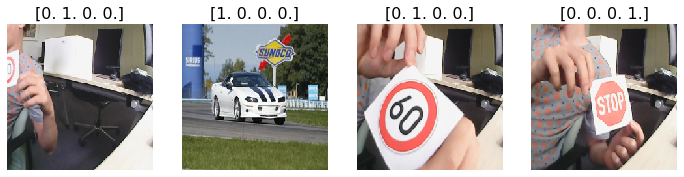

In [14]:
images, labels = next(train_batches)
plot_images(images[0:4], rows=1, interp=False, titles=labels, rescaled=True)

### Train configuration

Loss: function that measure the difference between the ground truth, and the result from the neural network.
* categorical coss-entropy: used in classification problems https://keras.io/losses/

Optimizer: method used to minimize (or maximize) the loss function, changing the weights of the neural network. 
https://keras.io/optimizers/

Metrics: function used to evaluate how well the neural network is performing.
https://keras.io/metrics/

In [1]:
loss = 'categorical_crossentropy'
optimizer = Adam(lr=.0001)
metrics = ['accuracy']

model.compile(optimizer, loss=loss, metrics=metrics)

NameError: name 'Adam' is not defined

In [29]:
# Number of times that the neural network will going to train over the dataset
# The neural network will learn more with more epochs
# If the neural network train over the dataset too much, it will have a problem of overfiting
# https://en.wikipedia.org/wiki/Overfitting
epochs = 10

model.fit_generator(train_batches, steps_per_epoch=step_size,
                    validation_data=validation_batches, validation_steps=step_size,
                    epochs=epochs,
                    verbose=1)                 


Epoch 1/2
266/266 [==============================] - 81s 305ms/step - loss: 0.1673 - acc: 0.9415 - val_loss: 0.0103 - val_acc: 0.9967
Epoch 2/2
266/266 [==============================] - 74s 278ms/step - loss: 0.0276 - acc: 0.9906 - val_loss: 0.0027 - val_acc: 0.9995


### Test

Now that the neural network is already trained, it is possible to analyse the accuracy of the model using the validation set.These images were not used in the training phase.

Prediction result: 
Label: traf_sign_60
Accuracy: 99.99641180038452


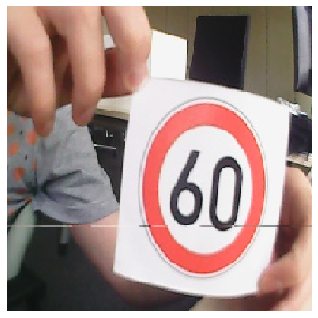

In [58]:
images, labels = next(validation_batches)
test_image = random.choice(images)
test_image = np.reshape(test_image, (-1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))

predictions = model.predict(test_image)

pred_max_value = np.max(predictions)
pred_max_index = np.argmax(predictions)

plot_images(test_image, rescaled=True)
print('Prediction result: ')
print('Label: ' + str(classes[pred_max_index]))
print('Accuracy: ' + str(pred_max_value*100))

### Save model and weights

The weights from the model can be saved after the training phase. In this way, it is possible to reuse the current state of the model without any necessity of training the model again. It is also possible to load the current model to continue training, if necessery. 

In [59]:
output_model_h5 = output_model_path + "/model.h5"
model.save(output_model_h5)